<a href="https://colab.research.google.com/github/seoyeon0905/mimic-readmission-analysis/blob/main/notebooks/05_readmission_risk_factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 본 프로젝트는 단계별 분석 파이프라인 형태로 구성되어 있으며 지금까지의 각 노트북은 다음과 같은 역할을 수행하였다.

## 01_data_loading.ipynb
- MIMIC-III Demo 데이터의 주요 테이블(PATIENTS, ADMISSIONS, ICUSTAYS 등)을 로드하고
병원 임상 데이터의 기본 구조와 테이블 간 관계를 확인하였다.

- 이후 코호트 정의와 분석을 위한 데이터 이해 단계에 해당한다.

---

## 02_cohort_definition.ipynb
- ICU에 입원한 환자 중 환자별 첫 입원(first admission)을 기준으로 분석 대상 cohort를 정의하였다.

- 입·퇴원 시점을 활용하여 30일 이내 재입원(readmission) 라벨을 생성하고
최종 분석용 데이터셋(**first_icu_admissions.csv**)을 구축하였다.

---

## 03_readmission_eda.ipynb
- 생성된 cohort를 대상으로 재입원 여부에 따른 기본적인 분포와 특성을 탐색하였다.

- 재입원 환자와 비재입원 환자 간의 차이를 인구학적 변수 및 입원 관련 변수 중심으로 확인하였다.

---

## 04_baseline_model.ipynb
- 제한된 기본 변수(age, ICU LOS)를 사용하여 30일 재입원 여부를 예측하는 간단한 baseline 모델을 구축하였다.

- 본 단계의 목적은 예측 성능 극대화가 아닌
**단순 변수 구성에서 얻을 수 있는 성능의 기준점(baseline)**을 설정하는 데 있다.

---

## 05_readmission_risk_factors.ipynb
- 위 단계에서 구축된 데이터와 분석 결과를 바탕으로
재입원 여부와 관련된 주요 위험 요인을 보다 집중적으로 비교·해석한다.

- 본 노트북에서는 앞선 단계에서 정의한 ICU 환자 cohort와
30일 이내 재입원(readmission) 라벨을 기반으로
재입원 여부와 관련된 주요 위험 요인(risk factors)을 분석한다.

- 단순히 예측 성능을 높이는 것을 목표로 하기보다는
재입원 환자와 비재입원 환자 간의 특성 차이를 비교하고
어떤 환자 및 입원 관련 변수들이 재입원 위험과 연관되어 있는지를
병원 임상 데이터 관점에서 해석하는 데 중점을 둔다.

In [1]:
# colab session setup
%cd /content
!rm -rf mimic-readmission-analysis
!git clone https://github.com/seoyeon0905/mimic-readmission-analysis.git
%cd mimic-readmission-analysis

/content
Cloning into 'mimic-readmission-analysis'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 215 (delta 37), reused 5 (delta 5), pack-reused 155 (from 1)
Receiving objects: 100% (215/215), 544.23 KiB | 2.36 MiB/s, done.
Resolving deltas: 100% (91/91), done.
/content/mimic-readmission-analysis


In [2]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 분석 데이터 로드(baseline과 동일)

In [3]:
df = pd.read_csv("data/processed/first_icu_admissions.csv")
df.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,hospital_expire_flag,has_chartevents_data,admission_order,next_admittime,days_to_next_admit,readmitted_30d,gender,dob,age,icu_los
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,0,1,1,NaN,NaN,0,F,2094-03-05,70,1.632546
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,...,1,1,1,NaN,NaN,0,F,2090-06-05,36,13.850694
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,1,1,1,NaN,NaN,0,F,2038-09-03,87,2.649907
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,0,1,1,NaN,NaN,0,F,2075-09-21,74,2.143611
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,1,1,1,NaN,NaN,0,M,2114-06-20,49,1.293843


In [5]:
# shape / outcome 분포 다시 확인하기
df.shape
df['readmitted_30d'].value_counts(normalize=True)
# 03, 04에서 봤더라도
# 05는 독립된 분석 노트북 -> 다시 한 번 컨텍스트 잡아줘야 함

,proportion
readmitted_30d,
0,0.92
1,0.08


# 분석할 risk factor 후보 정리
- 새 변수 만들지 말고 이미 있는 변수 중 해석 가능한 것만 선택하는 것이 포인트!

In [6]:
df.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'admission_order',
       'next_admittime', 'days_to_next_admit', 'readmitted_30d', 'gender',
       'dob', 'age', 'icu_los'],
      dtype='object')

## (1) 인구학적 요인
- age
- gender
- insurance
- ethnicity
- marital_status

## (2) 입원/중증도 proxy
- icu_los
- admission_type
- admission_location
- discharge_location
- hospital_expire_flag -> 해석 주의하기!!

In [9]:
risk_factors = [
    'age', 'gender', 'insurance', 'ethnicity', 'marital_status',
    'icu_los', 'admission_type', 'admission_location', 'discharge_location'
]

### <위험 요인 변수 선정 기준>
본 노트북에서는 30일 이내 재입원 여부와 관련된 위험 요인을 해석 중심으로 분석하기 위해 임상적으로 의미를 가지며 병원 환경에서 해석 가능한 변수들을 중심으로 분석 대상을 선정하였다.

- 먼저 연령, 성별, 보험 유형, 인종, 결혼 상태와 같은 인구학적 변수는 환자의 기본 특성과 사회, 경제적 배경을 반영하는 지표로
퇴원 이후 의료 접근성 및 관리 방식에 영향을 줄 수 있는 요인으로 판단하였다.

- 또한 ICU 재원 기간은 입원 당시 환자의 중증도를 간접적으로 나타내는 대표적인 지표로 활용하였다.
- 입원 유형, 입원 경로, 퇴원 경로는 환자가 어떤 방식으로 의료 시스템에 진입하고 퇴원 이후 어떤 환경으로 이동하는지를 나타내며 재입원 위험과 밀접한 관련이 있을 것으로 가정하였다.

- 반면, 다음 입원 시점과 같이 결과 정의에 직접적으로 연관되거나 미래 정보를 포함하는 변수들은 재입원 위험 요인 해석에 부적절하다고 판단하여 분석에서 제외하였다.

# 재입원 VS 비재입원 그룹 비교(핵심)
이게 05의 본체!!

- 수치형 변수
  - groupby().describe()
  - boxplot

- 범주형 변수
  - crosstab(normalize='index')
  - stacked bar plot

- 차이가 난다에서 끝내지 않고
  - 왜 그럴 수 있는지
  - 의료 시스템 관점 해

In [15]:
# (1) 수치형 변수
df.groupby('readmitted_30d')[['age', 'icu_los']].describe()

age                                                         \
               count        mean        std   min    25%   50%   75%    max   
readmitted_30d                                                                
0               92.0   87.304348  63.623677  17.0  64.75  76.0  86.0  300.0   
1                8.0  101.000000  81.444109  53.0  65.50  79.5  85.0  300.0   

               icu_los                                                    \
                 count      mean       std       min       25%       50%   
readmitted_30d                                                             
0                 92.0  4.913418  7.024265  0.105926  1.139618  2.259190   
1                  8.0  3.138245  2.189946  0.953808  1.889028  2.377263   

                                     
                     75%        max  
readmitted_30d                       
0               4.647656  35.406516  
1               3.791727   7.902014

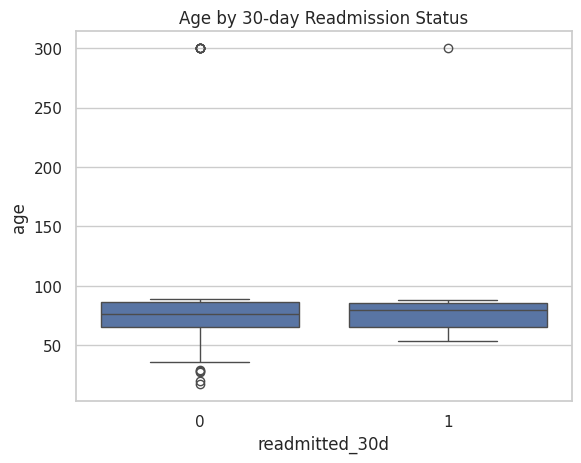

In [16]:
# 시각화
# Age
sns.boxplot(x='readmitted_30d', y='age', data=df)
plt.title("Age by 30-day Readmission Status")
plt.show()

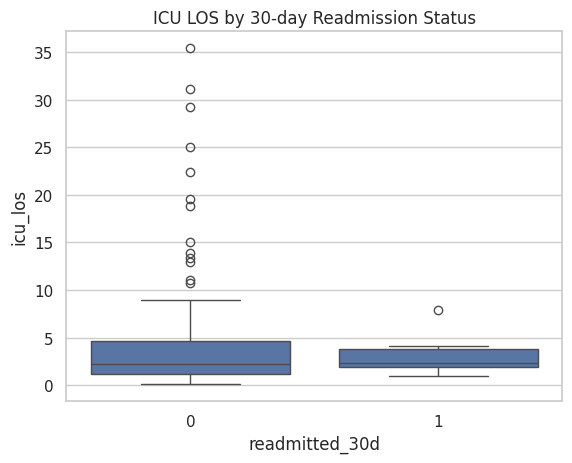

In [17]:
# ICU LOS
sns.boxplot(x='readmitted_30d', y='icu_los', data=df)
plt.title("ICU LOS by 30-day Readmission Status")
plt.show()

In [ ]:
# 재입원 환자군은 비재입원 환자군에 비해 ICU 재원 기간의 중앙값이 더 길게 나타났다.
# 이는 중증도가 높은 환자일수록 퇴원 이후에도 추가적인 입원 치료가 필요할 가능성이 높음을 시사한다.

In [11]:
# (2) 범주형 변수
pd.crosstab(df['insurance'], df['readmitted_30d'], normalize='index')

readmitted_30d,0,1
insurance,,
Government,1.000000,0.000000
Medicaid,1.000000,0.000000
Medicare,0.921053,0.078947
Private,0.894737,0.105263


Text(0.5, 1.0, 'Readmission Rate by Insurance Type')

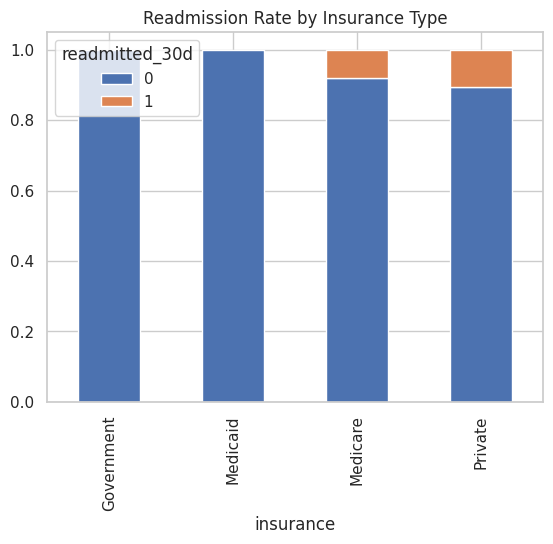

In [12]:
# 시각화
(pd.crosstab(df['insurance'], df['readmitted_30d'], normalize='index')
 .plot(kind='bar', stacked=True))
plt.title("Readmission Rate by Insurance Type")

In [ ]:
# 보험 유형에 따라 재입원 비율의 차이가 관찰되었다.
# 이는 사회, 경제적 요인이 퇴원 이후 의료 접근성이나
# 지속적인 외래 관리에 영향을 미칠 수 있음을 시사한다.

In [ ]:
# 여기서 차이가 난다 보다 중요한 것은
# 왜 그럴 수 있는지
# 의료 시스템 관점 해석

# 통계적 비교(가볍게만)
05에서는 통계 과시 하지 말기(차이가 우연일 가능성이 있는가? 정도만 확인하기)

In [13]:
from scipy.stats import ttest_ind

readmit = df[df['readmitted_30d'] == 1]['icu_los']
non_readmit = df[df['readmitted_30d'] == 0]['icu_los']

ttest_ind(readmit, non_readmit, equal_var=False)

TtestResult(statistic=np.float64(-1.6656804086541706), pvalue=np.float64(0.10895890496425442), df=np.float64(23.669800687214508))

In [ ]:
# 두 집단 간 분산이 동일하다고 가정하기 어려워
# welch's t-test(equal_var=False)를 사용하였다.

In [ ]:
# welch's t-test 결과 ICU 재원 기간의 평균 차이는
# 통계적으로 유의하지는 않았다. (p > 0.05)

# 다만 표본 수가 매우 제한적인 MIMIC-III demo 데이터의 특성을 고려할 때
# 본 분석에서는 통계적 유의성보다는
# 기술 통계 및 분포 차이에 기반한 해석에 중점을 두었다.

# 핵심 Risk Factor 요약(제일 중요!!!)

## 핵심 위험 요인 요약

기술 통계 및 집단 간 비교 분석 결과,
ICU 환자의 30일 이내 재입원 위험은 여러 요인과 연관되어
나타나는 경향이 관찰되었다.

ICU 재원 기간 분포를 비교한 결과,
재입원 환자군에서 ICU 재원 기간이 상대적으로 길게 나타나는
경향이 관찰되었으며,
이는 입원 당시 중증도가 높을수록 퇴원 이후에도
추가적인 입원 치료가 필요할 가능성이 있음을 시사한다.

또한 보험 유형 및 입원 경로에 따라 재입원 비율의 차이가 관찰되어,
사회·경제적 요인과 병원 내 치료 경로가
퇴원 이후 임상 결과에 영향을 미칠 수 있음을 보여준다.

종합적으로, 30일 이내 재입원 위험은
단순한 임상적 중증도뿐만 아니라
의료 접근성 및 치료·퇴원 과정과 같은
병원 시스템적 요인이 함께 작용한 결과로
해석할 수 있다.

본 분석은 예측 성능을 목적으로 하기보다는,
임상적으로 해석 가능한 위험 요인을 탐색하는
기술적 비교 분석임을 유의한다.